In [10]:
import ee
import geemap
import logging
import multiprocessing
import os
import torch
import pandas as pd
from skimage.measure.entropy import shannon_entropy
import numpy as np
import re
import rasterio
import matplotlib.pyplot as plt
import json
from utils.functions import getResult, getRequests, get_files_info
from sklearn.mixture import GaussianMixture

GEE_PROJECT_ID = "fusion-371234"
ee.Authenticate()
ee.Initialize(project=GEE_PROJECT_ID)

# Dataset

In [ ]:
Map = geemap.Map()
#The study area is in the district of Ejura-Sekyedumase, located in the northern part of
#the Ashanti Region of Ghana and situated within longitudes 1°5 W and 1°39’ W and latitudes
#7°9’ N and 7°36’ N
Map = geemap.Map(center=[7.375, -1.3667], zoom=20)
Map.add_basemap("HYBRID")
Map

In [ ]:
# Convert to GeoJSON format
geojson_dict = Map.user_roi.getInfo()

# Save to file
with open("ejura.json", "w") as f:
    json.dump(geojson_dict, f)

print("✅ Region saved as ejura.json")

## L8

In [ ]:
LANDSAT_COLLECTION_ID = "LANDSAT/LC08/C02/T1_L2"

# Landsat 8 Surface Reflectance band names (common)
selected_bands = [
    "SR_B1", "SR_B2", "SR_B3", "SR_B4", "SR_B5", "SR_B6", "SR_B7",  # Optical SR
]

CLOUD_FILTER = 20
PROCESSES = multiprocessing.cpu_count() - 1
dimensions = "256x256"
buffer = (int(dimensions.split('x')[0]) / 2) * 30   # Landsat = 30 m resolution
crs = "EPSG:4326"
num_samples = 4
DATE = ["2017-01-01", "2018-01-01"]
with open("ejura.json", "r") as f:
    region_data = json.load(f)

# Convert to Earth Engine Geometry
region = ee.Geometry(region_data)

with open("ejura.json", "r") as f:
    region_data = json.load(f)


params = {
    "count": num_samples,
    "buffer": buffer,
    "scale": 30,                   \
    "bands": None,
    "seed": 1,
    "dimensions": dimensions,
    "format": "GEO_TIFF",
    "prefix": "sample_",
    "processes": min(25, PROCESSES),
    "out_dir": "l8_ejura_2017_2018",
    "crs": crs,
}

landsat_col = ee.ImageCollection(LANDSAT_COLLECTION_ID).filterBounds(region).filterDate(DATE[0], DATE[1])

params['bands'] = [{
    'id': band, 
    'scale': 30,
    'crs': params['crs']} for band in selected_bands]


## Sentinel-2

In [16]:
S2_SR_COLLECTION_ID = "COPERNICUS/S2_HARMONIZED"
selected_bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']
CLOUD_FILTER = 30
PROCESSES = multiprocessing.cpu_count() - 1
dimensions = "256x256"
buffer = (int(dimensions.split('x')[0]) / 2) * 10 
crs = "EPSG:4326"
num_samples = 1
DATE = ["2018-01-01", "2019-01-01"]
with open("ejura.json", "r") as f:
    region_data = json.load(f)

# Convert to Earth Engine Geometry
region = ee.Geometry(region_data)

params = {
    "count": num_samples,  # How many image sample points to export
    "buffer": buffer,  # The buffer distance (m) around each point
    "scale": 10,  # The scale to do stratified sampling
    "bands": None, # The bands to export
    "seed": 1,  # A randomization seed to use for subsampling.
    "dimensions": dimensions,  # The dimension of each image chip
    "format": "GEO_TIFF",  # The output image format, can be png, jpg, ZIPPED_GEO_TIFF, GEO_TIFF, NPY
    "prefix": "sample_",  # The filename prefix
    "processes": min(25, PROCESSES),  # How many processes to used for parallel processing
    "out_dir": "s2_ejura_2018_2019",  # The output directory. Default to the current working directly
    "crs": crs,  # The CRS to use for the output image
}

s2_sr_col = ee.ImageCollection(S2_SR_COLLECTION_ID).filterBounds(region).filterDate(DATE[0], DATE[1]).filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', CLOUD_FILTER))


params['bands'] = [{
    'id': band, 
    'scale': (
        10 if band in ['B2', 'B3', 'B4', 'B8'] else 
        20 if band in ['B5', 'B6', 'B7', 'B8A', 'B11', 'B12'] else 
        60
    ), 
    'crs': params['crs']} for band in selected_bands]


In [17]:
images = []
samples = []
col_size = s2_sr_col.size().getInfo()
print(f"Number of images: {col_size}")
for i in range(col_size):
    sr_img = s2_sr_col.toList(s2_sr_col.size()).getInfo()[i]
    id = sr_img['properties']['PRODUCT_ID']
    sr_img = s2_sr_col.filter(ee.Filter.eq("PRODUCT_ID", id)).first()
    sr_img = sr_img.select(selected_bands)
    images.append(sr_img)
    samples.append(id)

os.makedirs(params['out_dir'], exist_ok=True)
for i in range(len(images)):
    image = images[i]
    id = samples[i]
    logging.basicConfig()
    items = getRequests(params, image, region)
    pool = multiprocessing.Pool(params["processes"])
    pool.starmap(getResult, [(index, item, image, params, id) for index, item in enumerate(items)])
    pool.close()      

Number of images: 26
Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2018_2019/20180102_S2A_MSIL1C_20180102T102421_N0500_R065_T30NXP_20230801T100953_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2018_2019/20180107_S2B_MSIL1C_20180107T102359_N0206_R065_T30NXP_20180107T122959_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2018_2019/20180112_S2A_MSIL1C_20180112T102401_N0206_R065_T30NXP_20180112T153609_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2018_2019/20180117_S2B_MSIL1C_20180117T102339_N0206_R065_T30NXP_20180117T140447_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2018_2019/20180122_S2A_MSIL1C_20180122T102321_N0500_R065_T30NXP_20230805T134106_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2018_2019/20180127_S2B_MSIL1C_20180127T102259_N0500_R065_T30NXP_20230805T195500_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2018_2019/20180201_S2A_MSIL1C_20180201T102241_N0206_R065_T30NXP_20180201T154521_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2018_2019/20180206_S2B_MSIL1C_20180206T102209_N0206_R065_T30NXP_20180206T154410_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2018_2019/20180211_S2A_MSIL1C_20180211T102141_N0206_R065_T30NXP_20180211T171719_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2018_2019/20180216_S2B_MSIL1C_20180216T102059_N0206_R065_T30NXP_20180216T153448_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2018_2019/20180303_S2A_MSIL1C_20180303T102021_N0206_R065_T30NXP_20180303T154452_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2018_2019/20180318_S2B_MSIL1C_20180318T102019_N0206_R065_T30NXP_20180318T130454_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2018_2019/20180412_S2A_MSIL1C_20180412T102021_N0206_R065_T30NXP_20180412T123033_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2018_2019/20180417_S2B_MSIL1C_20180417T102019_N0206_R065_T30NXP_20180417T155212_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2018_2019/20180422_S2A_MSIL1C_20180422T102031_N0206_R065_T30NXP_20180422T154603_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2018_2019/20180427_S2B_MSIL1C_20180427T102019_N0206_R065_T30NXP_20180427T130607_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2018_2019/20180616_S2B_MSIL1C_20180616T102019_N0206_R065_T30NXP_20180616T172531_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2018_2019/20180805_S2B_MSIL1C_20180805T102019_N0206_R065_T30NXP_20180805T160757_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2018_2019/20181014_S2B_MSIL1C_20181014T102019_N0206_R065_T30NXP_20181014T172055_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2018_2019/20181024_S2B_MSIL1C_20181024T102059_N0206_R065_T30NXP_20181024T172336_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2018_2019/20181108_S2A_MSIL1C_20181108T102231_N0207_R065_T30NXP_20181108T122729_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2018_2019/20181123_S2B_MSIL1C_20181123T102339_N0207_R065_T30NXP_20181123T135926_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2018_2019/20181203_S2B_MSIL1C_20181203T102359_N0207_R065_T30NXP_20181203T185431_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2018_2019/20181213_S2B_MSIL1C_20181213T102419_N0207_R065_T30NXP_20181213T123421_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2018_2019/20181218_S2A_MSIL1C_20181218T102431_N0207_R065_T30NXP_20181218T111403_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/s2_ejura_2018_2019/20181228_S2A_MSIL1C_20181228T102431_N0207_R065_T30NXP_20181228T111345_sample_0.tif


Total number of files: 22
Found 22 matching images.


/tmp/ipykernel_1883303/2725462744.py:45: UserWarning: Treat the new Tool classes introduced in v1.5 as experimental for now; the API and rcParam may change in future versions.
  plt.rcParams['toolbar'] = 'toolmanager'


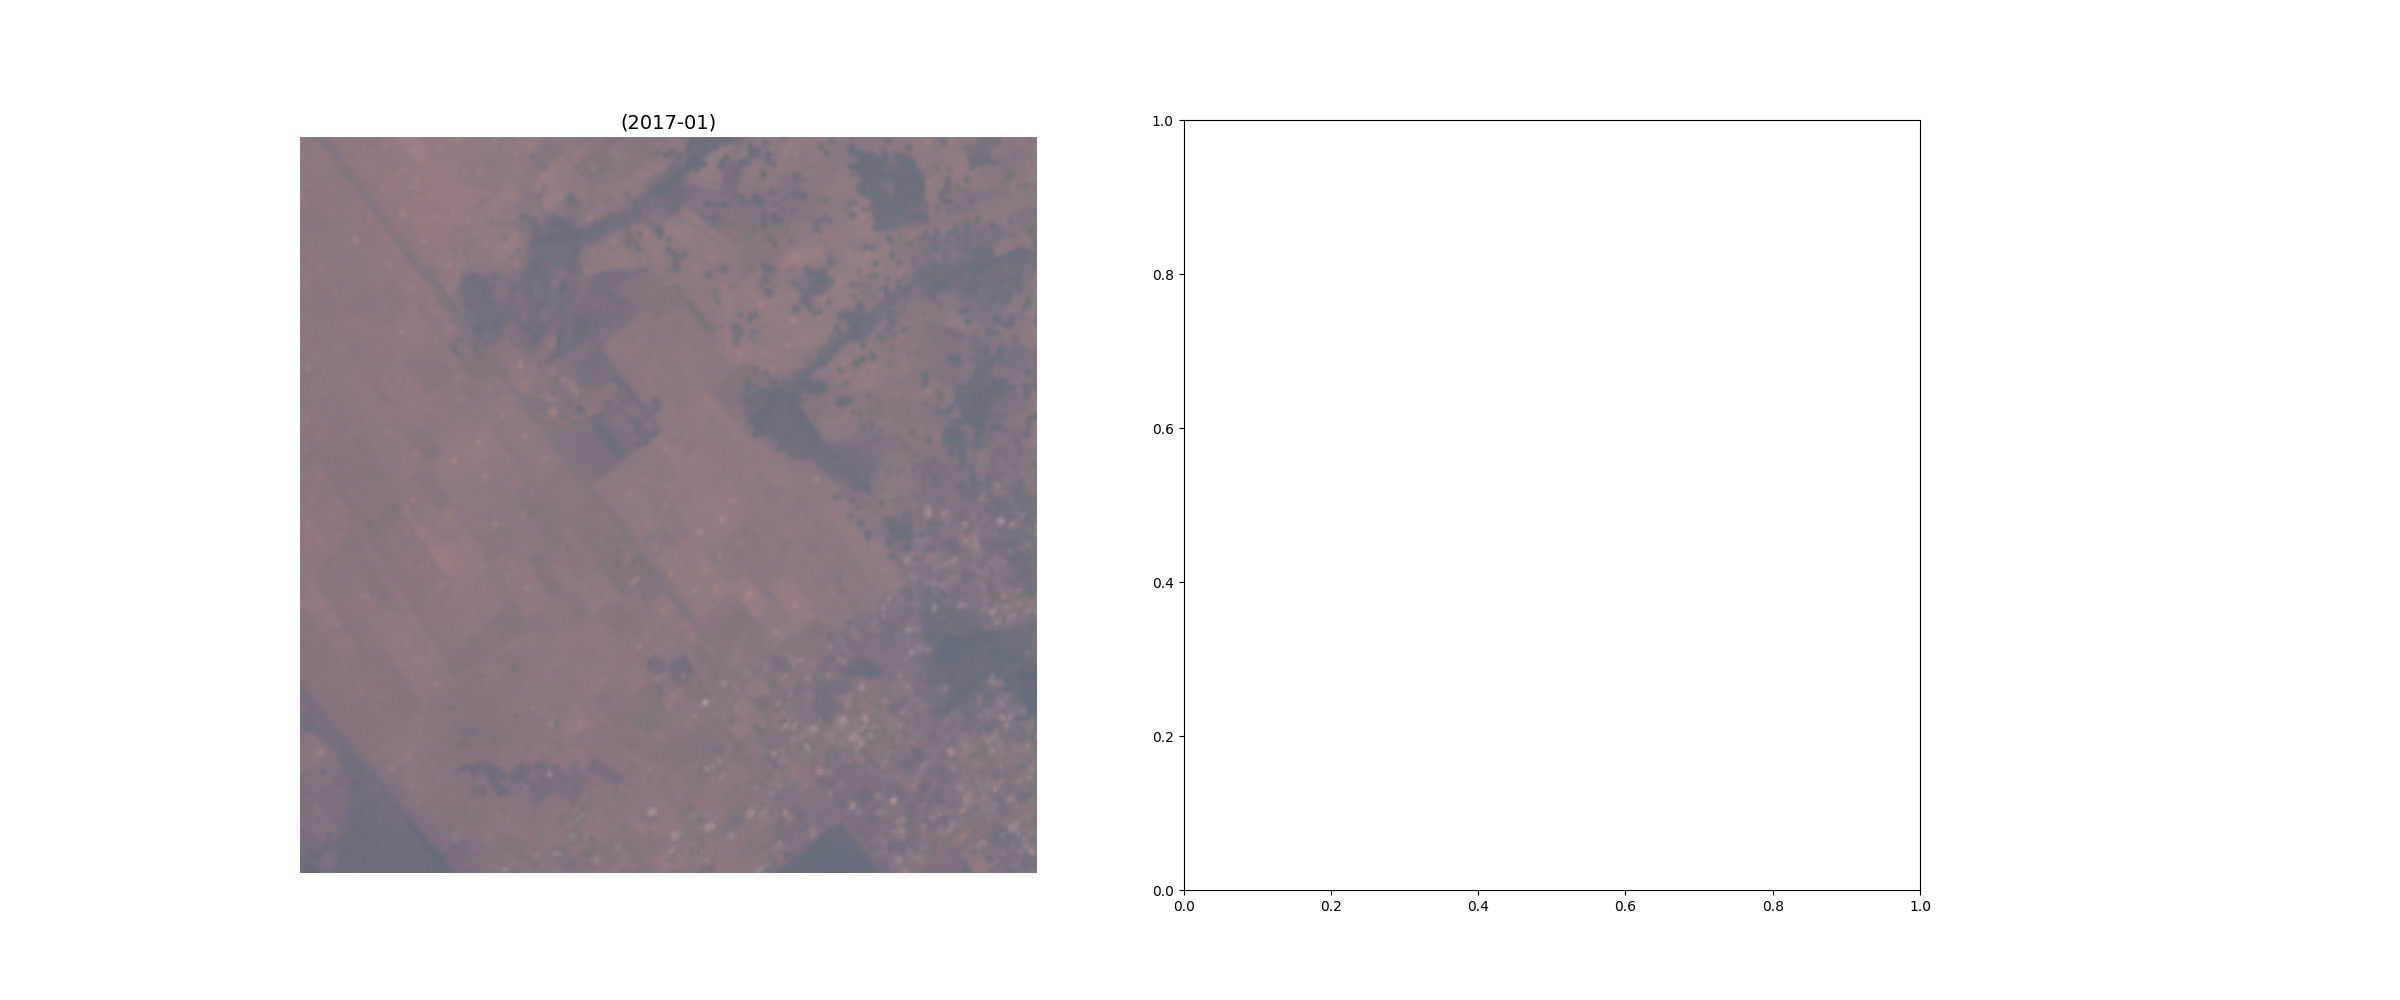

In [18]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import os
import re
from datetime import datetime
import matplotlib.dates as mdates

scale = 3000
sample_point = "0"
# OUTDIR = "ejura_2016_2017"
OUTDIR = "s2_ejura_2017_2018"
# OUTDIR = "ejura_2018_2019"
# OUTDIR = "ejura_2019_2020"

n_files, name_files = get_files_info(OUTDIR)
name_files = sorted(name_files)
matching_files = [f for f in name_files if re.match(rf".*_{sample_point}.*\.tif$", f)]
n_images = len(matching_files)
print(f"Found {n_images} matching images.")

file_paths = []
dates = []
for f in matching_files:
    file_paths.append(os.path.join(OUTDIR, f))
    match = re.search(r"_(\d{8})T", f)
    if match:
        date_str = match.group(1)
        date = datetime.strptime(date_str, "%Y%m%d")
        dates.append(date)
    else:
        dates.append(None)

n_image = 0
with rasterio.open(file_paths[n_image]) as src:
    img = src.read() / scale
img_rgb = np.clip(img[[3, 2, 1]].transpose(1, 2, 0), 0, 1)

fig, (ax_img, ax_spec) = plt.subplots(
    1, 2, figsize=(24, 10),
    gridspec_kw={'width_ratios': [1, 1]}
)
fig.subplots_adjust(right=0.8)
plt.rcParams['toolbar'] = 'toolmanager'

ax_img.imshow(img_rgb)
ax_img.set_title(f"({dates[n_image].strftime('%Y-%m')})", fontsize=14)
ax_img.axis("off")

def plot_ndvi_time_series(x, y):
    ax_spec.clear()
    ax_spec.set_title(f"NDVI Time-Series — pixel ({x}, {y})", fontsize=14)
    ax_spec.set_xlabel("Date")
    ax_spec.set_ylabel("NDVI")
    ax_spec.grid(True, linestyle="--")
    
    ndvi_values = []
    for file_path in file_paths:
        with rasterio.open(file_path) as src:
            img = src.read() / scale
        nir = img[7, y, x]   # banda 8 (NIR)
        red = img[3, y, x]   # banda 4 (RED)
        ndvi = (nir - red) / (nir + red + 1e-6)
        ndvi_values.append(ndvi)
    
    valid_pairs = sorted(
        [(d, n) for d, n in zip(dates, ndvi_values) if d is not None],
        key=lambda x: x[0]
    )
    sorted_dates, sorted_ndvi = zip(*valid_pairs)
    
    # Plot da série temporal
    ax_spec.plot(sorted_dates, sorted_ndvi, "o-", color="green", label="NDVI", markersize=6)
    
    # Destacar o ponto n_image
    if dates[n_image] is not None:
        highlight_date = dates[n_image]
        highlight_ndvi = ndvi_values[n_image]
        ax_spec.plot(highlight_date, highlight_ndvi, "o", color="red", 
                    markersize=12, markeredgewidth=2, markeredgecolor='darkred',
                    label=f"Current Image ({highlight_date.strftime('%Y-%d-%m')})", zorder=5)
    
    # Formatar eixo X para mostrar apenas Ano-Mês
    ax_spec.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax_spec.xaxis.set_major_locator(mdates.MonthLocator())
    plt.setp(ax_spec.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    ax_spec.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    # Destacar pixel clicado na imagem RGB
    ax_img.clear()
    ax_img.imshow(img_rgb)
    ax_img.plot(x, y, 'r+', markersize=15, markeredgewidth=2)
    ax_img.plot(x, y, 'ro', markersize=20, markerfacecolor='none', 
               markeredgewidth=2, markeredgecolor='red')
    ax_img.set_title(f"({dates[n_image].strftime('%Y-%m')}) - Pixel ({x}, {y})", fontsize=14)
    ax_img.axis("off")
    
    fig.canvas.draw_idle()

def onclick(event):
    if event.inaxes != ax_img:
        return
    x, y = int(event.xdata), int(event.ydata)
    print(f"Pixel clicked: ({x}, {y})")
    plot_ndvi_time_series(x, y)

fig.canvas.mpl_connect("button_press_event", onclick)
plt.show()

In [ ]:
%matplotlib widget


scale = 30000  # Landsat reflectance scaling
sample_point = "1"
OUTDIR = "l8_ejura_2018_2019"  # your Landsat folder

n_files, name_files = get_files_info(OUTDIR)
name_files = sorted(name_files)
matching_files = [f for f in name_files if re.match(rf".*_{sample_point}.*\.tif$", f)]
n_images = len(matching_files)
print(f"Found {n_images} matching images.")

file_paths = []
dates = []
for f in matching_files:
    file_paths.append(os.path.join(OUTDIR, f))
    # Extract Landsat acquisition date from 4th underscore-separated field
    parts = f.split("_")
    if len(parts) >= 4:
        date_str = parts[0]
        date = datetime.strptime(date_str, "%Y%m%d")
        dates.append(date)
    else:
        dates.append(None)

n_image = 4
with rasterio.open(file_paths[n_image]) as src:
    img = src.read() / scale

# RGB = [Red=B4, Green=B3, Blue=B2] → zero-indexed
img_rgb = np.clip(img[[3, 2, 1]].transpose(1, 2, 0), 0, 1)

fig, (ax_img, ax_spec) = plt.subplots(
    1, 2, figsize=(24, 10),
    gridspec_kw={'width_ratios': [1, 1]}
)
fig.subplots_adjust(right=0.8)
plt.rcParams['toolbar'] = 'toolmanager'

ax_img.imshow(img_rgb)
ax_img.set_title(f"({dates[n_image].strftime('%Y-%m')})", fontsize=14)
ax_img.axis("off")

def plot_ndvi_time_series(x, y):
    ax_spec.clear()
    ax_spec.set_title(f"NDVI Time-Series — pixel ({x}, {y})", fontsize=14)
    ax_spec.set_xlabel("Date")
    ax_spec.set_ylabel("NDVI")
    ax_spec.grid(True, linestyle="--")
    
    ndvi_values = []
    for file_path in file_paths:
        with rasterio.open(file_path) as src:
            img = src.read() / scale
        nir = img[4, y, x]   # NIR = B5
        red = img[3, y, x]   # RED = B4
        ndvi = (nir - red) / (nir + red + 1e-6)
        ndvi_values.append(ndvi)
    
    valid_pairs = sorted(
        [(d, n) for d, n in zip(dates, ndvi_values) if d is not None],
        key=lambda x: x[0]
    )
    sorted_dates, sorted_ndvi = zip(*valid_pairs)
    
    ax_spec.plot(sorted_dates, sorted_ndvi, "o-", color="green", label="NDVI", markersize=6)
    
    # Highlight the current image
    if dates[n_image] is not None:
        highlight_date = dates[n_image]
        highlight_ndvi = ndvi_values[n_image]
        ax_spec.plot(highlight_date, highlight_ndvi, "o", color="red", 
                     markersize=12, markeredgewidth=2, markeredgecolor='darkred',
                     label=f"Current Image ({highlight_date.strftime('%Y-%m-%d')})", zorder=5)
    
    # Format X-axis
    ax_spec.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax_spec.xaxis.set_major_locator(mdates.MonthLocator())
    plt.setp(ax_spec.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    ax_spec.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    # Highlight clicked pixel in RGB image
    ax_img.clear()
    ax_img.imshow(img_rgb)
    ax_img.plot(x, y, 'r+', markersize=15, markeredgewidth=2)
    ax_img.plot(x, y, 'ro', markersize=20, markerfacecolor='none', 
                markeredgewidth=2, markeredgecolor='red')
    ax_img.set_title(f"({dates[n_image].strftime('%Y-%m')}) - Pixel ({x}, {y})", fontsize=14)
    ax_img.axis("off")
    
    fig.canvas.draw_idle()                                              

def onclick(event):
    if event.inaxes != ax_img:
        return
    x, y = int(event.xdata), int(event.ydata)
    print(f"Pixel clicked: ({x}, {y})")
    plot_ndvi_time_series(x, y)

fig.canvas.mpl_connect("button_press_event", onclick)
plt.show()


In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import os
import re
from datetime import datetime
import matplotlib.dates as mdates

scale = 3000
sample_point = "1"
OUTDIR = "ejura_2018_2019"
# OUTDIR = "ejura_2019_2020"

n_files, name_files = get_files_info(OUTDIR)
name_files = sorted(name_files)
matching_files = [f for f in name_files if re.match(rf".*_{sample_point}.*\.tif$", f)]
n_images = len(matching_files)
print(f"Found {n_images} matching images.")

file_paths = []
dates = []
for f in matching_files:
    file_paths.append(os.path.join(OUTDIR, f))
    match = re.search(r"_(\d{8})T", f)
    if match:
        date_str = match.group(1)
        date = datetime.strptime(date_str, "%Y%m%d")
        dates.append(date)
    else:
        dates.append(None)

n_image = 12
with rasterio.open(file_paths[n_image]) as src:
    img = src.read() / scale
img_rgb = np.clip(img[[3, 2, 1]].transpose(1, 2, 0), 0, 1)

fig, (ax_img, ax_spec) = plt.subplots(
    1, 2, figsize=(24, 10),
    gridspec_kw={'width_ratios': [1, 1]}
)
fig.subplots_adjust(right=0.8)
plt.rcParams['toolbar'] = 'toolmanager'

ax_img.imshow(img_rgb)
ax_img.set_title(f"({dates[n_image].strftime('%Y-%m')})", fontsize=14)
ax_img.axis("off")

def plot_ndvi_time_series(x, y):
    ax_spec.clear()
    ax_spec.set_title(f"NDVI Time-Series — pixel ({x}, {y})", fontsize=14)
    ax_spec.set_xlabel("Date")
    ax_spec.set_ylabel("NDVI")
    ax_spec.grid(True, linestyle="--")
    
    ndvi_values = []
    for file_path in file_paths:
        with rasterio.open(file_path) as src:
            img = src.read() / scale
        nir = img[7, y, x]   # banda 8 (NIR)
        red = img[3, y, x]   # banda 4 (RED)
        ndvi = (nir - red) / (nir + red + 1e-6)
        ndvi_values.append(ndvi)
    
    valid_pairs = sorted(
        [(d, n) for d, n in zip(dates, ndvi_values) if d is not None],
        key=lambda x: x[0]
    )
    sorted_dates, sorted_ndvi = zip(*valid_pairs)
    
    # Plot da série temporal
    ax_spec.plot(sorted_dates, sorted_ndvi, "o-", color="green", label="NDVI", markersize=6)
    
    # Destacar o ponto n_image
    if dates[n_image] is not None:
        highlight_date = dates[n_image]
        highlight_ndvi = ndvi_values[n_image]
        ax_spec.plot(highlight_date, highlight_ndvi, "o", color="red", 
                    markersize=12, markeredgewidth=2, markeredgecolor='darkred',
                    label=f"Current Image ({highlight_date.strftime('%Y-%d-%m')})", zorder=5)
    
    # Formatar eixo X para mostrar apenas Ano-Mês
    ax_spec.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax_spec.xaxis.set_major_locator(mdates.MonthLocator())
    plt.setp(ax_spec.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    ax_spec.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    # Destacar pixel clicado na imagem RGB
    ax_img.clear()
    ax_img.imshow(img_rgb)
    ax_img.plot(x, y, 'r+', markersize=15, markeredgewidth=2)
    ax_img.plot(x, y, 'ro', markersize=20, markerfacecolor='none', 
               markeredgewidth=2, markeredgecolor='red')
    ax_img.set_title(f"({dates[n_image].strftime('%Y-%m')}) - Pixel ({x}, {y})", fontsize=14)
    ax_img.axis("off")
    
    fig.canvas.draw_idle()

def onclick(event):
    if event.inaxes != ax_img:
        return
    x, y = int(event.xdata), int(event.ydata)
    print(f"Pixel clicked: ({x}, {y})")
    plot_ndvi_time_series(x, y)

fig.canvas.mpl_connect("button_press_event", onclick)
plt.show()

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import rasterio

# Load image files
n_files, name_files = get_files_info(OUTDIR)
name_files = sorted(name_files)
scale = 5000
n_image = 60

with rasterio.open(f"{OUTDIR}/{name_files[n_image]}") as src:
    image = src.read() / scale
    rgb = np.clip(image[[3, 2, 1]].transpose(1, 2, 0), 0, 1)
    n_bands = image.shape[0]

fig, (ax_img, ax_spec) = plt.subplots(1, 2, figsize=(16, 8))

# Show RGB image
ax_img.imshow(rgb)
ax_img.axis("off")

# Prepare spectral plot
ax_spec.set_title("Spectral Response", fontsize=14)
ax_spec.set_xlabel("Band", fontsize=12)
ax_spec.set_ylabel("Reflectance", fontsize=12)
ax_spec.grid(True, linestyle="--")

# Set x-axis labels as B1, B2, B3, ...
band_labels = [f"B{i}" for i in range(1, n_bands + 1)]
ax_spec.set_xticks(np.arange(1, n_bands + 1))
ax_spec.set_xticklabels(band_labels, rotation=45, ha='right')

# Click callback
def onclick(event):
    if event.inaxes != ax_img:
        return
    
    x, y = int(event.xdata), int(event.ydata)
    print(f"Pixel clicked: ({x}, {y})")
    
    reflectance = image[:, y, x]
    
    # Add a new line for each click
    ax_spec.plot(np.arange(1, n_bands + 1), reflectance, "o-", label=f"({x},{y})")
    ax_spec.relim()
    ax_spec.autoscale_view()
    ax_spec.legend(loc="upper right", fontsize=10)
    fig.canvas.draw_idle()

fig.canvas.mpl_connect("button_press_event", onclick)
plt.show()
plt.savefig("spectral_responses", dpi=150, bbox_inches='tight')

In [ ]:
# Define the study area - two towns: Anci and Yongqing
roi_large = ee.Geometry.Rectangle([116.5, 39.2, 116.9, 39.4])

# Create map
Map = geemap.Map(center=[39.3, 116.7], zoom=11)
Map.add_basemap("HYBRID")

# Load Sentinel-2 image from August 18, 2019
s2 = ee.ImageCollection('COPERNICUS/S2_SR') \
    .filterDate('2019-08-15', '2019-08-22') \
    .filterBounds(roi_large) \
    .sort('CLOUDY_PIXEL_PERCENTAGE') \
    .first()

# ==========================================
# STEP 1: Classify corn vs non-corn areas
# ==========================================

# Select bands for land cover classification
bands_classify = ['B2', 'B3', 'B4', 'B8', 'B11', 'B12']
s2_classify = s2.select(bands_classify)

# Calculate vegetation indices for classification
ndvi = s2.normalizedDifference(['B8', 'B4']).rename('NDVI')
ndwi = s2.normalizedDifference(['B3', 'B8']).rename('NDWI')  # Water index
ndbi = s2.normalizedDifference(['B11', 'B8']).rename('NDBI')  # Built-up index

# Combine features for classification
features_classify = s2_classify.addBands([ndvi, ndwi, ndbi])

# Create training samples for land cover types
# You would need to define these based on your study area
# The authors manually collected samples for:
# - Corn
# - Buildings/Urban
# - Other crops (soybean, peanut, apple trees)
# - Bare soil
# - Water

# Example: Simple rule-based classification (simplified version)
# For a proper RF classification, you'd need training samples

# Corn areas: high NDVI, low NDBI (not built-up), low NDWI (not water)
corn_mask = ndvi.gt(0.4).And(ndbi.lt(0)).And(ndwi.lt(0.1))

# Urban/built-up: high NDBI
urban_mask = ndbi.gt(0.1)

# Water: high NDWI
water_mask = ndwi.gt(0.3)

# Other vegetation: moderate NDVI but not corn
other_veg_mask = ndvi.gt(0.3).And(ndvi.lte(0.4)).And(ndbi.lt(0))

# Create land cover classification
land_cover = ee.Image(0)  # Initialize with 0 (non-corn)
land_cover = land_cover.where(corn_mask, 1)  # Corn = 1
land_cover = land_cover.where(urban_mask, 2)  # Urban = 2
land_cover = land_cover.where(water_mask, 3)  # Water = 3
land_cover = land_cover.where(other_veg_mask, 4)  # Other veg = 4

# ==========================================
# STEP 2: Random Forest Classification (proper method)
# ==========================================

# Define training points (you'd collect these from field data or visual interpretation)
# Example training data structure:
training_points = ee.FeatureCollection([
    ee.Feature(ee.Geometry.Point([116.752, 39.355]), {'class': 1}),  # Corn
    ee.Feature(ee.Geometry.Point([116.755, 39.360]), {'class': 2}),  # Urban
    ee.Feature(ee.Geometry.Point([116.745, 39.350]), {'class': 3}),  # Water
    # Add more training points...
])

# Sample the features at training points
training = features_classify.sampleRegions(
    collection=training_points,
    properties=['class'],
    scale=10
)

# Train Random Forest classifier
# The authors achieved OA = 0.92 for land cover classification
rf_classifier = ee.Classifier.smileRandomForest(
    numberOfTrees=100,
    minLeafPopulation=1
).train(
    features=training,
    classProperty='class',
    inputProperties=features_classify.bandNames()
)

# Classify the image
land_cover_rf = features_classify.classify(rf_classifier)

# Create corn mask (class 1 = corn)
corn_mask_rf = land_cover_rf.eq(1)

# ==========================================
# STEP 3: Apply mask and classify pest levels
# ==========================================

# Calculate NDVI for pest level classification (only for corn areas)
ndvi_corn = ndvi.updateMask(corn_mask_rf)

# Classify pest levels (only in corn areas)
level0 = ndvi_corn.gt(0.522).multiply(0)  # Healthy
level1 = ndvi_corn.gte(0.23).And(ndvi_corn.lte(0.522)).multiply(1)
level2 = ndvi_corn.gte(0.12).And(ndvi_corn.lt(0.23)).multiply(2)
level3 = ndvi_corn.gte(0.01).And(ndvi_corn.lt(0.12)).multiply(3)
level4 = ndvi_corn.lt(0.01).multiply(4)

pest_levels = level0.add(level1).add(level2).add(level3).add(level4).rename('pest_level')

# Add non-corn areas as Level 5 (as in the paper)
pest_levels_final = pest_levels.where(corn_mask_rf.eq(0), 5)

# ==========================================
# Visualization
# ==========================================

# Sentinel-2 true color
vis_true = {
    'bands': ['B4', 'B3', 'B2'],
    'min': 0,
    'max': 3000,
    'gamma': 1.4
}

# Land cover visualization
vis_landcover = {
    'min': 0,
    'max': 4,
    'palette': ['gray', 'green', 'red', 'blue', 'lightgreen']
}

# Pest levels visualization (matching Figure 9 in the paper)
vis_pest = {
    'min': 0,
    'max': 5,
    'palette': ['green', 'yellow', 'orange', 'red', 'darkred', 'lightgray']
    # 0=healthy, 1=little damage, 2=medium, 3=heavy, 4=very heavy, 5=non-corn
}

# Add layers
Map.addLayer(s2, vis_true, 'Sentinel-2 True Color')
Map.addLayer(land_cover, vis_landcover, 'Land Cover (Simple)', False)
Map.addLayer(corn_mask_rf, {'palette': ['white', 'green']}, 'Corn Mask', False)
Map.addLayer(pest_levels_final, vis_pest, 'Pest Damage Levels')
Map.addLayer(roi_large, {'color': 'yellow'}, 'Study Area')

Map.centerObject(roi_large, 11)
Map